In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

import sklearn
from sklearn.inspection import permutation_importance

from sklearn.utils import class_weight

import os
import numpy as np

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

from keras.utils import plot_model

from datetime import datetime
from datetime import timedelta

#!pip install seaborn
#import seaborn as sns

In [3]:
def prepare_x_y_data(input_csv):
    # Read in formatted data
    data = pd.read_csv(input_csv, index_col = False)
    data = data.fillna(0)
    
    ### Delete unneeded columns - we currently include data from all sensors (even incomplete ones)
    sensor_ids = data['sensor_id']
    #data = data.drop(['sensor_id'],axis=1) # don't want this included
    # Get rid of columns in which none of the sensors have a value
    for column in data.columns:
        if np.nanmax(data[column]) ==0:
            del data[column]
            
    # Filter columns using the regex pattern in function input
    regex_pattern = 'buildings$|street_inf$|landmarks$'
    data = data[data.columns.drop(list(data.filter(regex=regex_pattern)))].copy()
    
    ### Add a random variable (to compare performance of other variables against)
    rng = np.random.RandomState(seed=42)
    data['random'] = np.random.random(size=len(data))
    data["random_cat"] = rng.randint(3, size=data.shape[0])
    
    ## Prepare data for modelling 
    ### Split into predictor/predictand variables
    Xfull = data.drop(['hourly_counts'], axis =1)
    Yfull = data['hourly_counts'].values
       
    ### Store the (non Sin/Cos) time columns and then remove them (Need them later to segment the results by hour of the day)
    data_time_columns = Xfull[['day_of_month_num', 'time', 'weekday_num', 'time_of_day', 'datetime']]
    #Xfull = Xfull.drop(['day_of_month_num', 'time', 'weekday_num', 'time_of_day','datetime', 'month_num'],axis=1)
    Xfull = Xfull.drop(['day_of_month_num', 'time', 'weekday_num', 'time_of_day', 'month_num'],axis=1)
    return Xfull, Yfull, data_time_columns

## Time series forecasting

In [4]:
def normalize(df, target_column):
    
    result = df.copy()
    
    for feature_name in df.columns:
        
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        
        if feature_name == 'footfall':
            result['footfall_norm'] = (df[feature_name] - min_value) / (max_value - min_value)
            
        else:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    
    cols = list(result.columns)
    column_list = cols[:-2] + cols[-1:] + cols[-2:-1]
    result = result[column_list]
    
    return result

In [74]:
buffer_size_m = 400
input_csv ="formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)

X_data, Y_data, data_time_columns = prepare_x_y_data(input_csv)

X_data = X_data.iloc[:2198889]
Y_data = Y_data[:2198889]
data_time_columns = data_time_columns.iloc[:2198889]

In [75]:
# Find the sensors that have continuous data throughout the time period (no hourly gaps)

sensor_and_date = X_data.iloc[:,:2]
for _id in set(sorted(sensor_and_date['sensor_id'])):
    
    datetimes = list(sensor_and_date.loc[sensor_and_date['sensor_id']== _id, 'datetime'])
    empty_list = []
    
    for i in range(len(datetimes)-1):
        if datetime.strptime(datetimes[i+1], "%Y-%m-%d %H:%M:%S") != datetime.strptime(datetimes[i], "%Y-%m-%d %H:%M:%S") + timedelta(hours=1):
            empty_list.append(1)
            break
    
    if sum(empty_list) < 1:
        print(_id)
           

49
51
54


In [76]:
sensor_id = 54

In [77]:
X_data = X_data.loc[X_data['sensor_id'] == sensor_id]
Y_data = Y_data[X_data.loc[X_data['sensor_id'] == sensor_id].index]
data_time_columns = data_time_columns.iloc[X_data.loc[X_data['sensor_id'] == sensor_id].index]

In [78]:
drop_features = ['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'month_2', 
                 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 
                 'month_10', 'month_11', 'month_12', 'year', 'random', 'random_cat', 'datetime', 'sensor_id']

In [79]:
df = X_data.copy()
df['footfall'] = Y_data
df.drop(drop_features, axis=1, inplace=True)

In [80]:
footfall_max = df['footfall'].max()
footfall_min = df['footfall'].min()

In [81]:
n=len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [82]:
features = ['Temp', 'Humidity' ,'Pressure', 'Rain', 'WindSpeed', 'Rainfall amount (millimetres)', 'public_holiday' ,'school_holiday',
           'Sin_time','Cos_time','Sin_month_num','Cos_month_num','Sin_weekday_num','Cos_weekday_num', 'footfall']  
features = ['footfall']

In [83]:
train_df = train_df.loc[:, features]
val_df = val_df.loc[:, features]
test_df = test_df.loc[:, features]

In [84]:
num_features = df.shape[1]

In [85]:
train_df = normalize(train_df, 'footfall')
val_df = normalize(val_df, 'footfall')
test_df = normalize(test_df, 'footfall')

In [86]:
train_df = train_df.dropna(axis='columns')
val_df = val_df.dropna(axis='columns')
test_df = test_df.dropna(axis='columns')

In [87]:
train_df

,footfall_norm,footfall
1904197,0.010919,12
1904230,0.010009,11
1904262,0.020018,22
1904340,0.010919,12
1904381,0.002730,3
...,...,...
2111189,0.034577,38
2111279,0.044586,49
2111294,0.063694,70
2111330,0.081893,90


In [88]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
    
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}
    
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
    
        self.total_window_size = input_width + shift
    
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        
        inputs = features[:, self.input_slice, -1:]
        labels = features[:, self.labels_slice, :]
        #print(inputs.shape)
        #inputs[:,:,-1] = (inputs[:,:,-1] - footfall_min) / (footfall_max - footfall_min)

        
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)
    
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
    
        return inputs, labels

In [89]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['footfall'])

In [90]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

In [91]:
example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 2)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


In [92]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

In [93]:
def plot(self, model=None, plot_col='footfall', max_subplots=10):
    
    inputs, labels = self.example
    plt.figure(figsize=(12, 18))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    print(max_n)
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index-1],
                 label='Inputs', marker='.', zorder=-10)
    
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
    
        if label_col_index is None:
            continue
    
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n,label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
    
        if n == 0:
            plt.legend()
    
    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [94]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [26]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping],
                       verbose=1)
    return history

In [27]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [28]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [139]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [140]:
print('Input shape:', w2.example[0].shape)
print('Output shape:', lstm_model(w2.example[0]).shape)

Input shape: (32, 6, 1)
Output shape: (32, 1)


In [29]:
val_performance = {}
performance = {}

In [142]:
history = compile_and_fit(lstm_model, w2)

Epoch 1/200
136/136 [==============================] - 2s 6ms/step - loss: 50991.5273 - mean_absolute_error: 163.4813 - val_loss: 13640.7139 - val_mean_absolute_error: 85.8450
Epoch 2/200
136/136 [==============================] - 1s 4ms/step - loss: 48404.4453 - mean_absolute_error: 156.6038 - val_loss: 12806.5000 - val_mean_absolute_error: 82.3469
Epoch 3/200
136/136 [==============================] - 1s 4ms/step - loss: 47012.4219 - mean_absolute_error: 153.3901 - val_loss: 12106.1758 - val_mean_absolute_error: 79.6371
Epoch 4/200
136/136 [==============================] - 1s 4ms/step - loss: 45806.7070 - mean_absolute_error: 150.7983 - val_loss: 11573.3965 - val_mean_absolute_error: 77.5675
Epoch 5/200
136/136 [==============================] - 1s 4ms/step - loss: 44791.0586 - mean_absolute_error: 148.4811 - val_loss: 11080.0508 - val_mean_absolute_error: 75.3608
Epoch 6/200
136/136 [==============================] - 1s 4ms/step - loss: 43835.0742 - mean_absolute_error: 146.1798 - 

In [73]:
val_performance = {}
performance = {}

lstm_model = tf.keras.models.load_model('sensor_49_window_6_model')

val_performance['LSTM'] = lstm_model.evaluate(w2.val)
performance['LSTM'] = lstm_model.evaluate(w2.test, verbose=1)

val_mean_absolute_error = val_performance['LSTM'][1]
print('Mean absolute error:', val_mean_absolute_error)

test_mean_absolute_error = performance['LSTM'][1]
print('Mean absolute error:', test_mean_absolute_error)

36/36 [==============================] - 0s 3ms/step - loss: 2980.5771 - mean_absolute_error: 34.8732
Mean absolute error: 37.429080963134766
Mean absolute error: 34.873172760009766


In [35]:
val_performance = {}
performance = {}

lstm_model = tf.keras.models.load_model('sensor_51_window_6_model')

val_performance['LSTM'] = lstm_model.evaluate(w2.val)
performance['LSTM'] = lstm_model.evaluate(w2.test, verbose=1)

val_mean_absolute_error = val_performance['LSTM'][1]
print('Mean absolute error:', val_mean_absolute_error)

test_mean_absolute_error = performance['LSTM'][1]
print('Mean absolute error:', test_mean_absolute_error)

36/36 [==============================] - 0s 2ms/step - loss: 1474.8257 - mean_absolute_error: 27.0548
Mean absolute error: 23.32754898071289
Mean absolute error: 27.05481719970703


In [95]:
val_performance = {}
performance = {}

lstm_model = tf.keras.models.load_model('sensor_54_window_6_model')

val_performance['LSTM'] = lstm_model.evaluate(w2.val)
performance['LSTM'] = lstm_model.evaluate(w2.test, verbose=1)

val_mean_absolute_error = val_performance['LSTM'][1]
print('Mean absolute error:', val_mean_absolute_error)

test_mean_absolute_error = performance['LSTM'][1]
print('Mean absolute error:', test_mean_absolute_error)

20/20 [==============================] - 0s 2ms/step - loss: 24373.2500 - mean_absolute_error: 89.9146
Mean absolute error: 27.27423667907715
Mean absolute error: 89.91464233398438


10


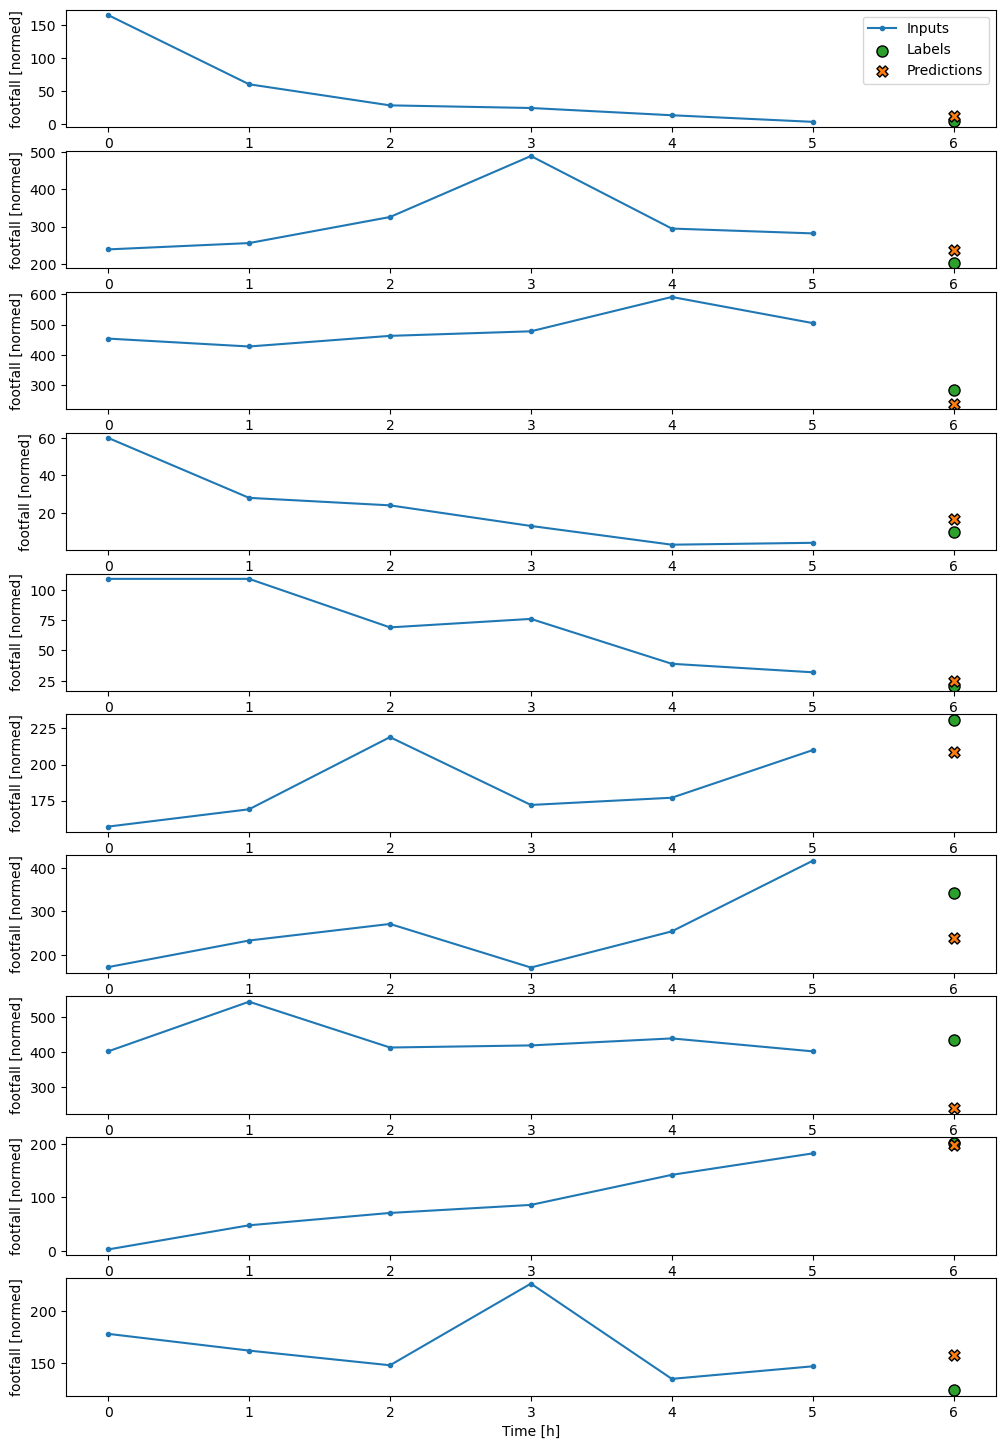

In [146]:
w2.plot(lstm_model)

In [147]:
sensor_id

54

In [148]:
lstm_model.save('sensor_54_window_6_model')

INFO:tensorflow:Assets written to: sensor_54_window_6_model/assets


INFO:tensorflow:Assets written to: sensor_54_window_6_model/assets


## Loop through different sliding windows and save the result

In [ ]:
for window_width in range(1,25):
    
    w2 = WindowGenerator(input_width=window_width, label_width=1, shift=1, label_columns=['footfall'])
    
    lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=False),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
    ])
    
    print('Input shape:', w2.example[0].shape)
    print('Output shape:', lstm_model(w2.example[0]).shape)
    
    val_performance = {}
    performance = {}
    
    history = compile_and_fit(lstm_model, w2)
    
    val_performance['LSTM'] = lstm_model.evaluate(w2.val)[1]
    performance['LSTM'] = lstm_model.evaluate(w2.test, verbose=1)[1]
    
    
    np.save('./window_sensitivity/mae_window_' + "{:02}".format(window_width) + '.npy', performance['LSTM'])
    
    print(window_width)

Input shape: (32, 1, 1)
Output shape: (32, 1)
Epoch 1/200
248/248 [==============================] - 3s 5ms/step - loss: 94329.3750 - mean_absolute_error: 206.4486 - val_loss: 65391.3398 - val_mean_absolute_error: 176.0223
Epoch 2/200
248/248 [==============================] - 1s 4ms/step - loss: 90801.1172 - mean_absolute_error: 198.0101 - val_loss: 62104.8281 - val_mean_absolute_error: 166.6669
Epoch 3/200
248/248 [==============================] - 1s 3ms/step - loss: 87548.1328 - mean_absolute_error: 190.1988 - val_loss: 59597.0469 - val_mean_absolute_error: 159.4660
Epoch 4/200
248/248 [==============================] - 1s 3ms/step - loss: 84944.2500 - mean_absolute_error: 184.2302 - val_loss: 57591.4414 - val_mean_absolute_error: 153.9372
Epoch 5/200
248/248 [==============================] - 1s 3ms/step - loss: 82688.1953 - mean_absolute_error: 179.4131 - val_loss: 55756.0234 - val_mean_absolute_error: 149.1594
Epoch 6/200
248/248 [==============================] - 1s 3ms/step - 

In [43]:
y = [np.load('./window_sensitivity/mae_window_' + time + '.npy') for time in ["{:02}".format(n) for n in range(1,25)]] 

In [50]:
x = [n for n in range(0,24)]

In [ ]:
plt.plot(x,y)

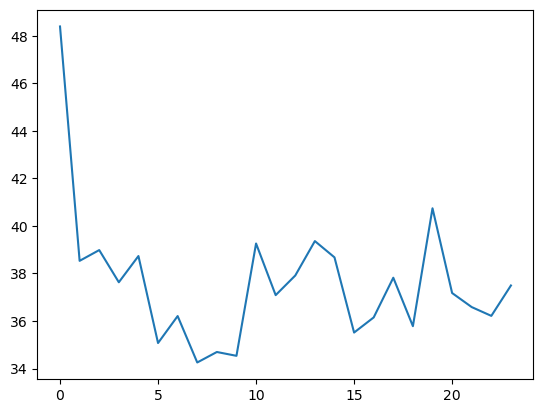

In [51]:
plt.plot(x,y)